In [49]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error


In [50]:
df = pd.read_csv("dataset.csv", index_col="ts", parse_dates = True)
df.head()

id    light  temperature  soil_moisture  humidity  \
ts                                                                       
2025-04-01 21:15:00   1  34.3262      33.3125         3262.0        84   
2025-04-01 21:30:00   2  33.9057      33.4688         3232.5        84   
2025-04-01 21:45:00   3  33.2979      33.5938         3218.0        85   
2025-04-01 22:00:00   4  33.6201      33.3281         3211.0        85   
2025-04-01 22:15:00   5  33.2979      33.3438         3203.0        85   

                     api_temp  precipitation  cloud_cover  
ts                                                         
2025-04-01 21:15:00      27.9            0.1          100  
2025-04-01 21:30:00      27.8            0.1          100  
2025-04-01 21:45:00      27.8            0.1          100  
2025-04-01 22:00:00      27.6            0.0          100  
2025-04-01 22:15:00      27.6            0.0          100

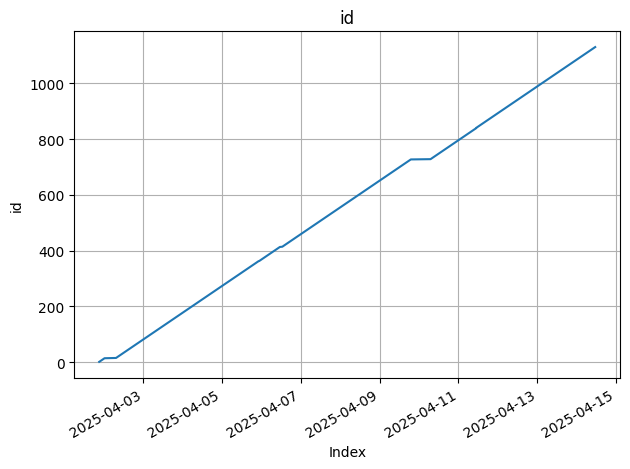

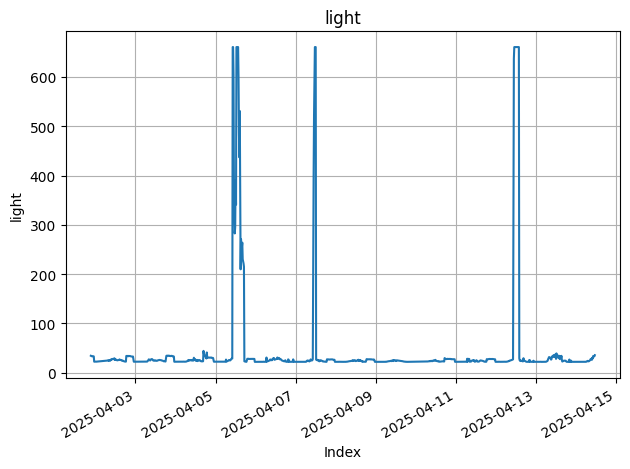

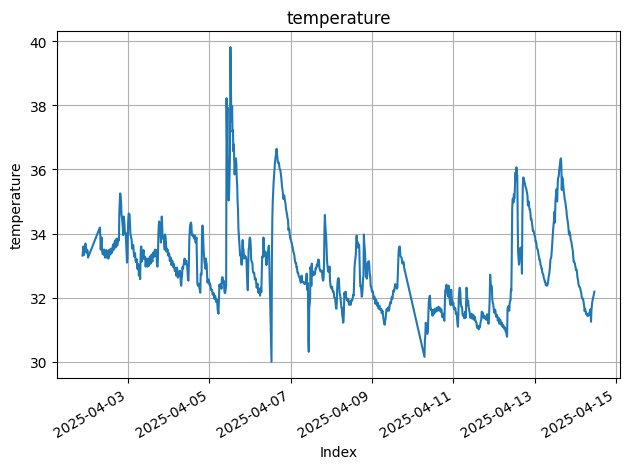

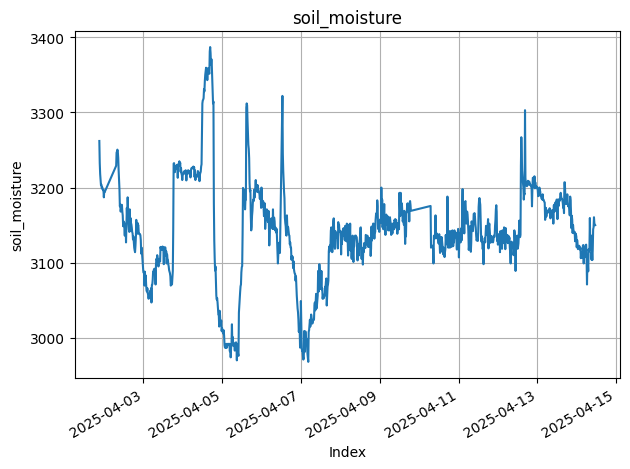

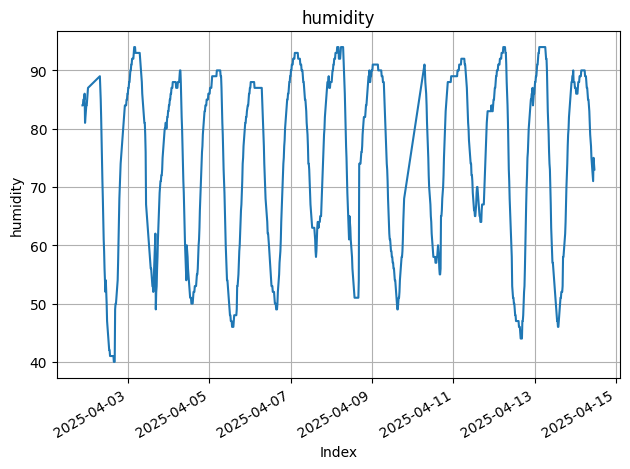

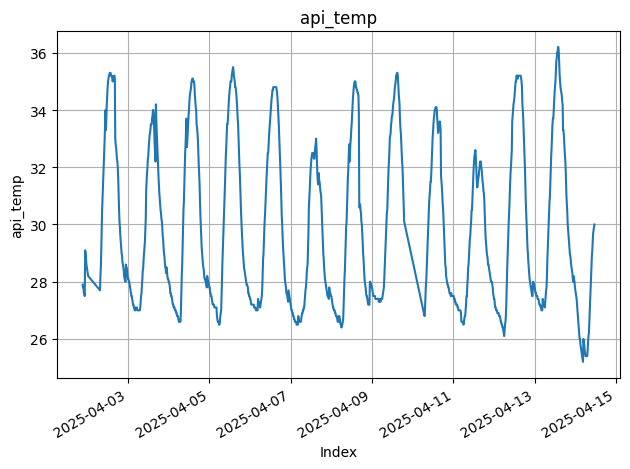

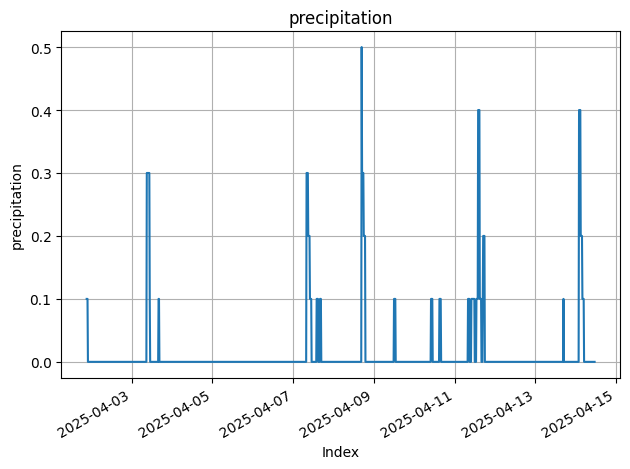

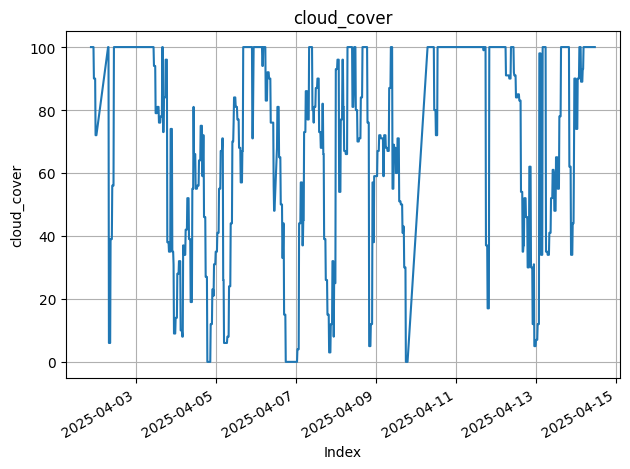

In [51]:
for column in df.columns:
    plt.figure()  # Create a new figure for each plot
    df[column].plot()
    plt.title(column)
    plt.xlabel("Index")  # or "Date" if it's time series
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<Axes: >

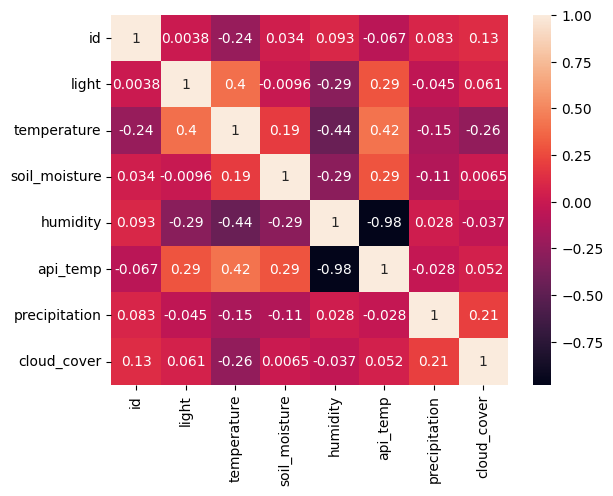

In [52]:
sns.heatmap(df.corr(),annot=True)

# EDA

In [53]:
df["soil_moisture"].diff().dropna()

ts
2025-04-01 21:30:00   -29.5
2025-04-01 21:45:00   -14.5
2025-04-01 22:00:00    -7.0
2025-04-01 22:15:00    -8.0
2025-04-01 22:30:00     1.0
                       ... 
2025-04-14 10:15:00     2.5
2025-04-14 10:30:00    13.5
2025-04-14 10:45:00    -8.5
2025-04-14 11:00:00    -1.0
2025-04-14 11:15:00    -1.0
Name: soil_moisture, Length: 1129, dtype: float64

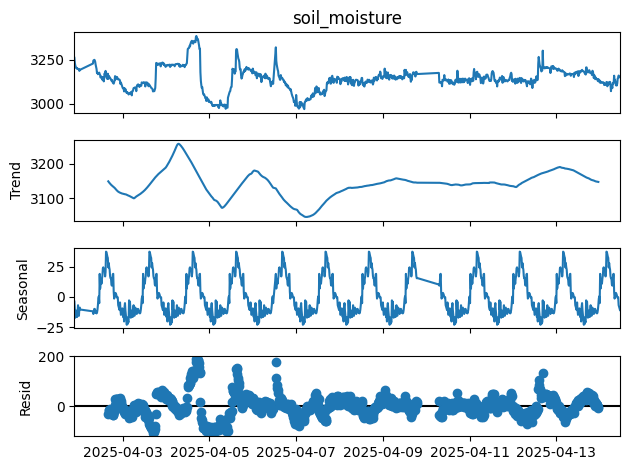

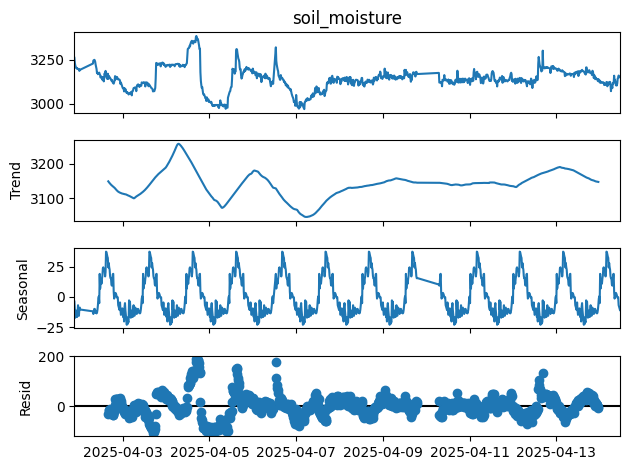

In [54]:
seasonal_decompose(df["soil_moisture"], model="additive", period=96).plot()


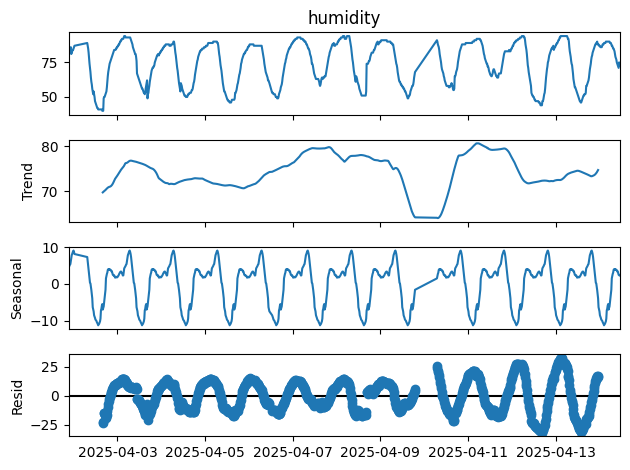

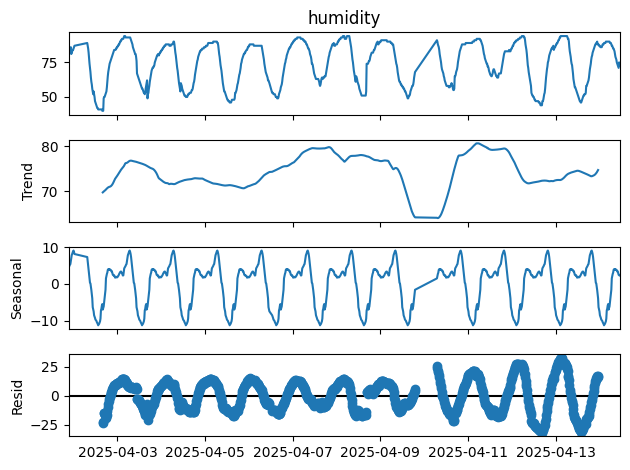

In [55]:
seasonal_decompose(df["humidity"], model="additive", period=96).plot()

## Find D parameter

In [56]:
result = adfuller(df["soil_moisture"].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -3.84682253492801
p-value: 0.0024629935755944216
Critial Values:
   1%, -3.4361604996756685
Critial Values:
   5%, -2.864105678204421
Critial Values:
   10%, -2.568136037454102


Since p-value is less than 0.05, the data is stationary and no differencing is needed.

Therefore, we use d=0.

## Find P parameter

<BarContainer object of 25 artists>

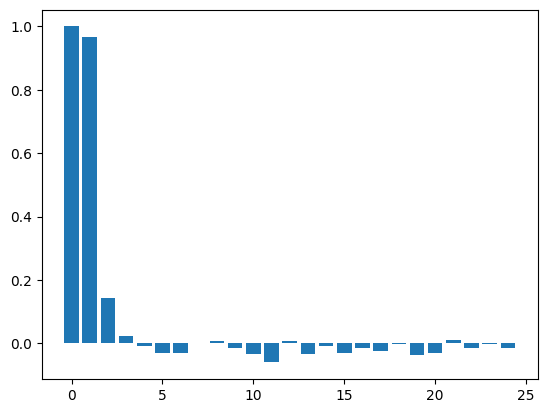

In [57]:
# I believe 2 or 3 is the variable for the term AR in order
pacf_vals = pacf(df["soil_moisture"])
# where did 25 came from?
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])

There are 2 exceptionally high bars, therefore, p=2

## Find Q parameter

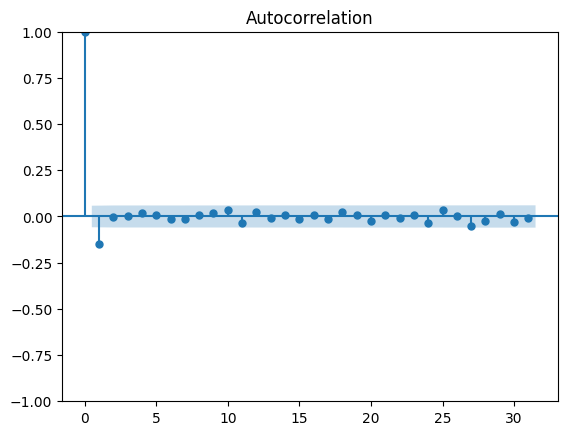

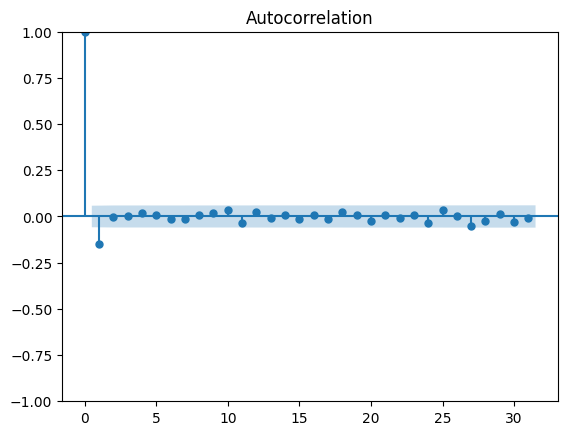

In [58]:
plot_acf(df["soil_moisture"].diff().dropna())

## Separate the test and train data

In [59]:
train_end = datetime(2025,4,9)
test_end = datetime(2025,4,11)

train_data = df[:train_end]
test_data = df[train_end:test_end]
# test_data = df[train_end + timedelta(days=1):test_end]

In [60]:
train_data.head()

id    light  temperature  soil_moisture  humidity  \
ts                                                                       
2025-04-01 21:15:00   1  34.3262      33.3125         3262.0        84   
2025-04-01 21:30:00   2  33.9057      33.4688         3232.5        84   
2025-04-01 21:45:00   3  33.2979      33.5938         3218.0        85   
2025-04-01 22:00:00   4  33.6201      33.3281         3211.0        85   
2025-04-01 22:15:00   5  33.2979      33.3438         3203.0        85   

                     api_temp  precipitation  cloud_cover  
ts                                                         
2025-04-01 21:15:00      27.9            0.1          100  
2025-04-01 21:30:00      27.8            0.1          100  
2025-04-01 21:45:00      27.8            0.1          100  
2025-04-01 22:00:00      27.6            0.0          100  
2025-04-01 22:15:00      27.6            0.0          100

In [61]:
test_data.head()

id    light  temperature  soil_moisture  humidity  \
ts                                                                        
2025-04-09 00:00:00  651  22.0622      32.1875         3155.0        90   
2025-04-09 00:15:00  652  21.9617      32.2188         3157.5        90   
2025-04-09 00:30:00  653  22.0118      32.1875         3155.0        91   
2025-04-09 00:45:00  654  22.0118      32.1094         3153.0        91   
2025-04-09 01:00:00  655  22.0118      31.9688         3200.0        91   

                     api_temp  precipitation  cloud_cover  
ts                                                         
2025-04-09 00:00:00      27.8            0.0           59  
2025-04-09 00:15:00      27.7            0.0           59  
2025-04-09 00:30:00      27.6            0.0           59  
2025-04-09 00:45:00      27.5            0.0           59  
2025-04-09 01:00:00      27.5            0.0           67

In [62]:
train_data[["soil_moisture"]]

soil_moisture
ts                                
2025-04-01 21:15:00         3262.0
2025-04-01 21:30:00         3232.5
2025-04-01 21:45:00         3218.0
2025-04-01 22:00:00         3211.0
2025-04-01 22:15:00         3203.0
...                            ...
2025-04-08 23:00:00         3145.0
2025-04-08 23:15:00         3150.5
2025-04-08 23:30:00         3147.0
2025-04-08 23:45:00         3141.0
2025-04-09 00:00:00         3155.0

[651 rows x 1 columns]

wtf?

In [63]:
test_data['soil_moisture'].count()



146

## Train the model

In [ ]:
model = SARIMAX(
    endog=test_data['soil_moisture'],
    exog=test_data[['temperature','humidity','api_temp']],  # Use DataFrame/Series, not column name
    order=(2,0,0)
)
results = model.fit()
results.summary()

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          soil_moisture   No. Observations:                  146
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -632.803
Date:                Fri, 18 Apr 2025   AIC                           1275.606
Time:                        16:13:59   BIC                           1290.524
Sample:                             0   HQIC                          1281.668
                                - 146                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      12.4227      0.430     28.876      0.000      11.580      13.266
api_temp      73.2818      1.104     66.354      0.000      71.117      75.446
ar.L1          0.7564      0.085      8.893      0.000       0.590       0.923
ar.L2          0.1533      0.081      1.898      0.058      -0.005       0.312
sigma2       336.7657     39.651      8.493      0.000     259.052     414.479
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.09
Prob(Q):                              0.92   Prob(JB):                         0.35
Heteroskedasticity (H):               1.05   Skew:                             0.23
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
prediction = pd.DataFrame(results.predict(n_periods = int(test_data['soil_moisture'].count()), index=test_data.index))
prediction.columns = ['predicted']
prediction

predicted
ts                              
2025-04-09 00:00:00  3155.276095
2025-04-09 00:15:00  3147.701270
2025-04-09 00:30:00  3160.225199
2025-04-09 00:45:00  3148.659307
2025-04-09 01:00:00  3151.525214
...                          ...
2025-04-10 23:00:00  3126.829834
2025-04-10 23:15:00  3118.750396
2025-04-10 23:30:00  3134.822985
2025-04-10 23:45:00  3136.003149
2025-04-11 00:00:00  3141.594350

[146 rows x 1 columns]

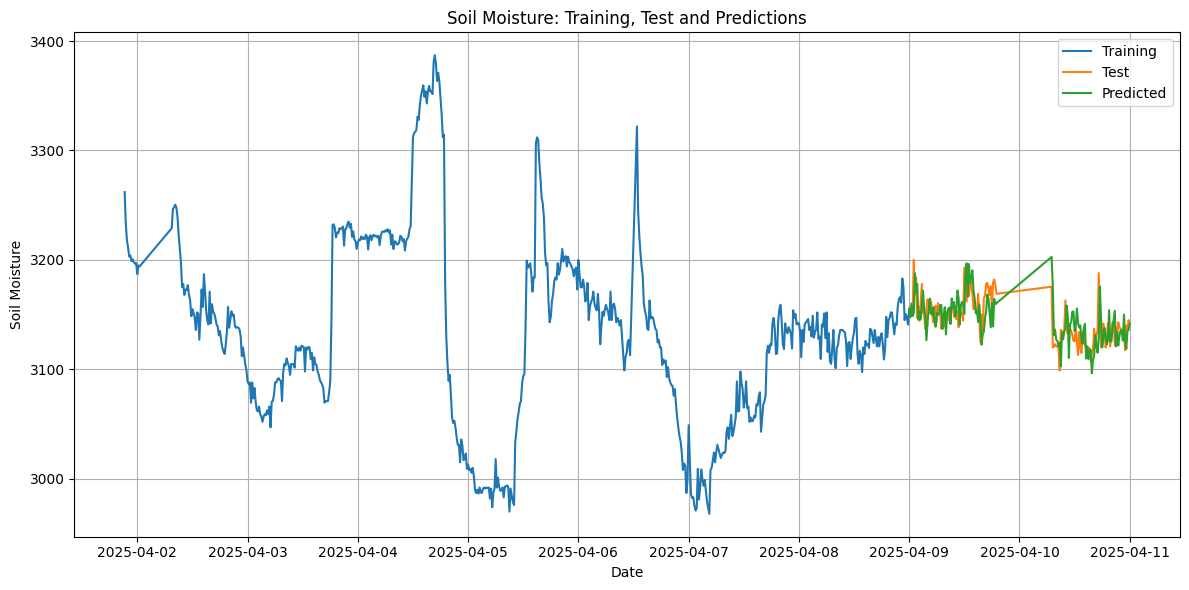

In [66]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
test_data.count()

id               146
light            146
temperature      146
soil_moisture    146
humidity         146
api_temp         146
precipitation    146
cloud_cover      146
dtype: int64

In [68]:
prediction.count()

predicted    146
dtype: int64

In [69]:
# Get the RMSE
rmse = root_mean_squared_error(test_data['soil_moisture'], prediction)
print(rmse)

18.351502309378045


## Train again for two times with 2 sets of parameters

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


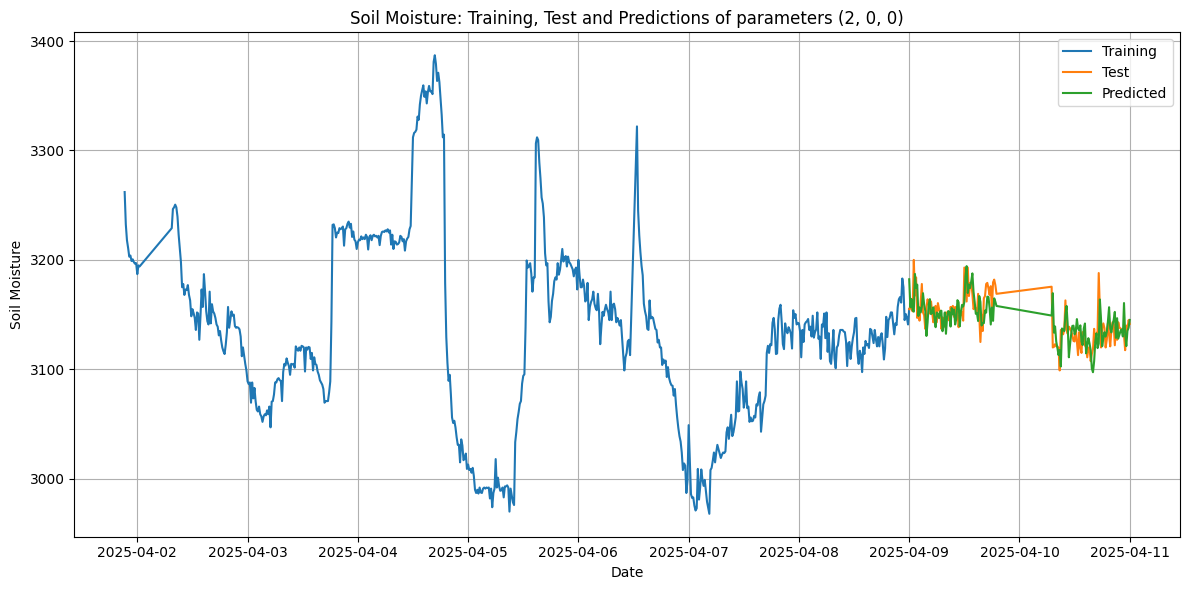

RMSE of (2, 0, 0) is :  17.10091295775935


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


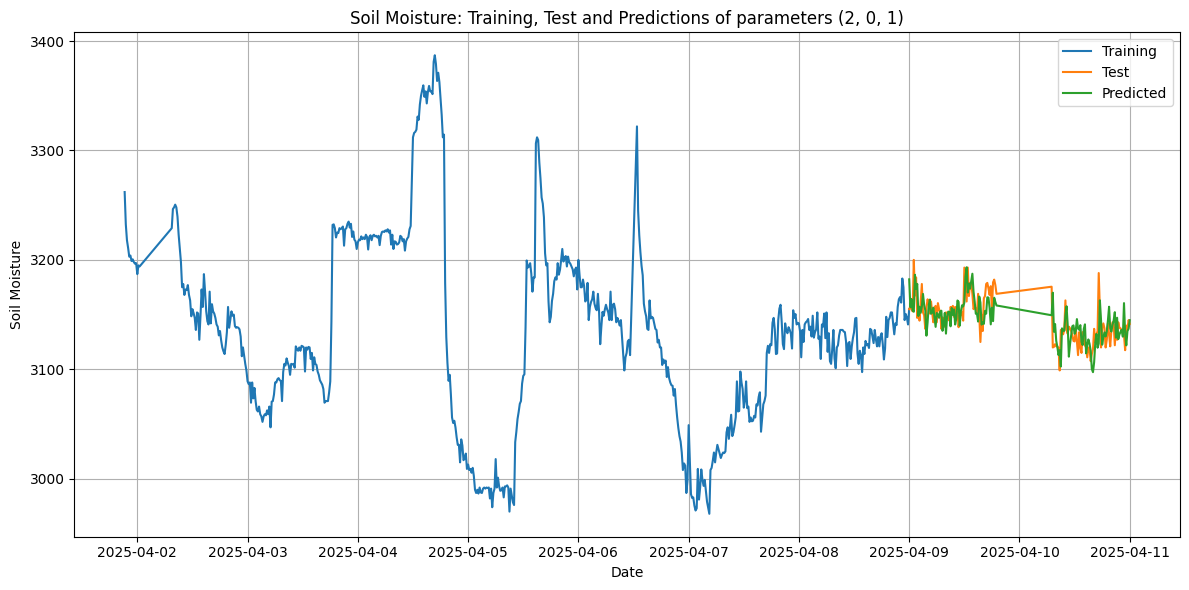

RMSE of (2, 0, 1) is :  17.090555222145493


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


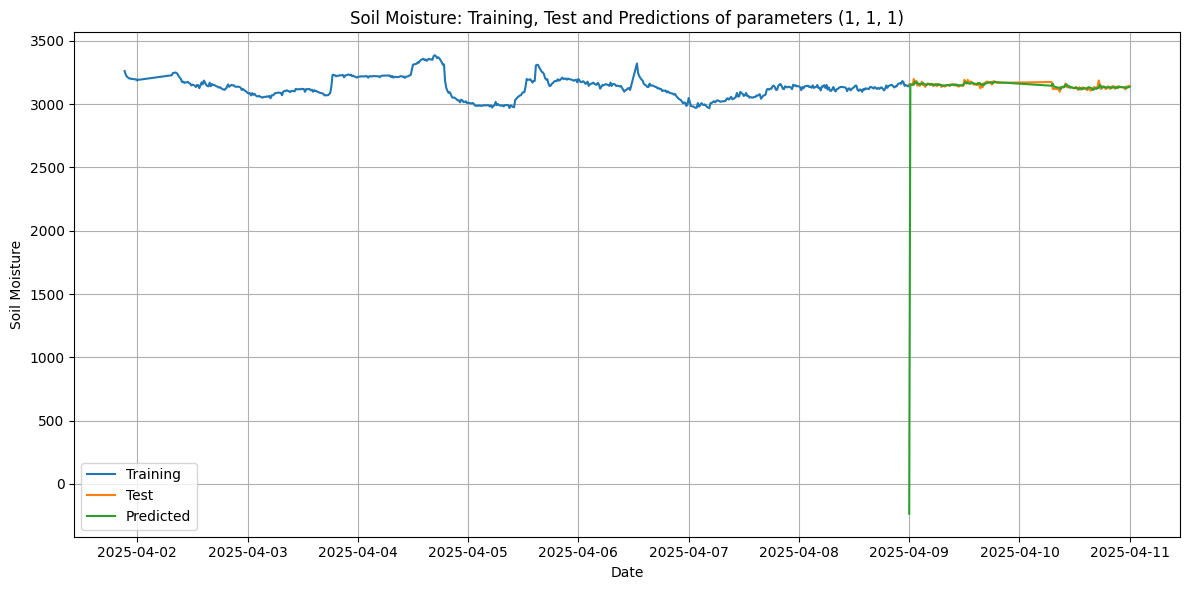

RMSE of (1, 1, 1) is :  281.06031919269986


In [74]:
parameters = [(2,0,0), (2,0,1), (1,1,1)]
for order in parameters:
    model = SARIMAX(
        endog=test_data['soil_moisture'],
        exog=test_data[['temperature','humidity','api_temp','precipitation']],  # Use DataFrame/Series, not column name
        order=order
    )
    results = model.fit()

    prediction = pd.DataFrame(results.predict(n_periods = int(test_data['soil_moisture'].count()), index=test_data.index))
    prediction.columns = ['predicted']

    plt.figure(figsize=(12, 6))
    # Ensure datetime index and proper plotting
    plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
    plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
    plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Soil Moisture")
    plt.title(f"Soil Moisture: Training, Test and Predictions of parameters {str(order)}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"RMSE of {order} is : ", root_mean_squared_error(test_data['soil_moisture'], prediction))


In [71]:
train_data.head()

id    light  temperature  soil_moisture  humidity  \
ts                                                                       
2025-04-01 21:15:00   1  34.3262      33.3125         3262.0        84   
2025-04-01 21:30:00   2  33.9057      33.4688         3232.5        84   
2025-04-01 21:45:00   3  33.2979      33.5938         3218.0        85   
2025-04-01 22:00:00   4  33.6201      33.3281         3211.0        85   
2025-04-01 22:15:00   5  33.2979      33.3438         3203.0        85   

                     api_temp  precipitation  cloud_cover  
ts                                                         
2025-04-01 21:15:00      27.9            0.1          100  
2025-04-01 21:30:00      27.8            0.1          100  
2025-04-01 21:45:00      27.8            0.1          100  
2025-04-01 22:00:00      27.6            0.0          100  
2025-04-01 22:15:00      27.6            0.0          100

In [72]:
test_data.head()

id    light  temperature  soil_moisture  humidity  \
ts                                                                        
2025-04-09 00:00:00  651  22.0622      32.1875         3155.0        90   
2025-04-09 00:15:00  652  21.9617      32.2188         3157.5        90   
2025-04-09 00:30:00  653  22.0118      32.1875         3155.0        91   
2025-04-09 00:45:00  654  22.0118      32.1094         3153.0        91   
2025-04-09 01:00:00  655  22.0118      31.9688         3200.0        91   

                     api_temp  precipitation  cloud_cover  
ts                                                         
2025-04-09 00:00:00      27.8            0.0           59  
2025-04-09 00:15:00      27.7            0.0           59  
2025-04-09 00:30:00      27.6            0.0           59  
2025-04-09 00:45:00      27.5            0.0           59  
2025-04-09 01:00:00      27.5            0.0           67